In [1]:
# AE and VAE Studies with Yale Face Database
# Create a Variational Auto Encoder and feed Yale Face Database to the model to extract the average and important facial features

# Dataset: https://www.kaggle.com/kerneler/starter-yale-face-database-c5f3978b-5
# Download all the dataset to the same folder and name this dataset folder as data

import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms

(243, 320) 77760 <class 'numpy.ndarray'>


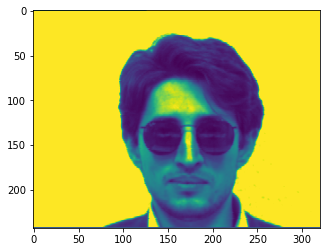

In [2]:
# to view an instance in the data folder manually, pick a random sample 
# the instances are 2d numpy arrays that can be viewed as RGB images

import matplotlib.image as mpimg 
img = mpimg.imread('./data/subject03.glasses') 
plt.imshow(img) 
print(img.shape, img.size, type(img)) 

In [3]:
# Import all the file names in the "data folder" into a list 

all_file_names_data = []
import os
for files in os.walk('./data', topdown=True): 
    for each_file in files:
        all_file_names_data.append(each_file)

In [4]:
# Import all the image files into a list since there are some other file types in the data folder

# 1- remove the unrelated files from the all_file_names_data
# print(all_file_names_data[0], all_file_names_data[1]) : directory name and an empty list
img_file_names_data = all_file_names_data[2:]

# 2- sort the names in the img_file_names_data list 
all_images_data = []
img_file_names_in_data = sorted(img_file_names_data) # sort it so that each subjects images stay put together
for file_name_list in img_file_names_data:
    for each_file in file_name_list:
        if each_file.startswith('subject'):
            # print(each_file)
            np_image = mpimg.imread('./data/' + each_file)
            all_images_data.append(np_image)
print(all_images_data[9].shape) # each instance is a 2d array with size 243 x 320 
print(len(all_images_data)) # total 165 instances; total 11 people (subjects) each having 15 photos

# take a close look at one of the samples that is 243 x 320. 
print(all_images_data[0]) # the values are between 0 and 255. 

(243, 320)
165
[[130 130 130 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 230 229]
 [255 255 255 ... 251 222 224]
 [ 68  68  68 ...  68  68  68]]


In [5]:
# Normalize the arrays to [0,1] and then store it in a list

all_scaled_images = []
for each_image in all_images_data:
    scaled_image = transforms.functional.to_tensor(each_image) # transformation automatically normalizes the values
    all_scaled_images.append(scaled_image)
print(all_scaled_images[0], all_scaled_images[0].shape) # each image has this dimention: torch.Size([1, 243, 320])
# print('max value', max(all_scaled_images[0])) # double checking all values are between 0 and 1

tensor([[[0.5098, 0.5098, 0.5098,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9020, 0.8980],
         [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.8706, 0.8784],
         [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667]]]) torch.Size([1, 243, 320])


/Users/volkansonmez/miniconda/lib/python3.7/site-packages/torchvision/transforms/functional.py:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


In [6]:
# Flatten all the images into 2 dimensions with this format: (1, 243*320) with: .view(-1, 243*320) function

all_flattened_scaled_images = []
for each_item in all_scaled_images:
    flattened_image = each_item.view(-1, 243*320)
    all_flattened_scaled_images.append(flattened_image)
print(len(all_flattened_scaled_images))
print(all_flattened_scaled_images[9].shape)
print(all_flattened_scaled_images[2])
training_data = all_flattened_scaled_images

165
torch.Size([1, 77760])
tensor([[0.5098, 0.5098, 0.5098,  ..., 0.2667, 0.2667, 0.2667]])


In [7]:
# Define the network model & parameters 

# set a manual seed and the device name to GPU if it is available

d = 30 # number of dimensions at the bottleneck where latent space is defined
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(243*320, 60*80),
            nn.ReLU(),
            nn.Linear(60*80, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 60 * 80),
            nn.ReLU(),
            nn.Linear(60 * 80, 243 * 320),
            nn.Sigmoid(), # since all values should be between 0 and 1
        )

    def reparameterise(self, mu, logvar): # compute the standard deviation (std) from log variance (logvar)
        # compute the standard deviation (std) from log variance (logvar).
        if self.training:
            # logvar is: std == (approximately) Var**0.5 == Exp(0.5*log(Variance) ~== standard dev.
            std = logvar.mul(0.5).exp_() # .mul multiplies each element of a variable with a constant in the paranthesis
            eps = std.data.new(std.size()).normal_() # create a normal distribution with the new standard dev.
            # Z = MU + Epsilon * Variance**0.5 == Eps + logvar approximation + MU == Eps * std + MU
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x).view(-1, 2, d) # torch.Size([1, 2, 30])  two arrays with length 30
        mu = mu_logvar[:, 0, :] #  torch.Size([1, 30])  first array
        logvar = mu_logvar[:, 1, :]  #  torch.Size([1, 30]) second array 
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar # logvar is the approximation of the standard deviation ==~ log(Variance)

    
model = VAE().to(device)


In [8]:
# Set the optimiser and hyper-parameters

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# define the loss function: Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_hat, x) # reconstruction loss for multi-colors
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2)) # KL divergence loss

    return BCE + KLD

In [9]:
# Before training the model, pass one image throught the model to check the output & hyper-parameter values

# prevent exploding gradients in the model by squeezing and monitoring the values 
torch.autograd.set_detect_anomaly(True)
torch.nn.utils.clip_grad_norm(model.parameters(), max_norm = 5) 

random_x = training_data[1]
x_hat, mu, logvar = model(random_x)

print(random_x[:5], mu[:5], logvar[:5], x_hat[:5])

tensor([[0.4353, 0.3725, 0.3529,  ..., 0.2667, 0.2667, 0.2667]]) tensor([[-0.0172,  0.0741,  0.0288,  0.0318,  0.0141, -0.0771,  0.0450,  0.0121,
          0.0137, -0.0081, -0.1126,  0.0929, -0.1526, -0.0425,  0.0288,  0.0222,
         -0.0273,  0.0259,  0.0933, -0.0839,  0.0387,  0.1091,  0.0607,  0.0998,
          0.0214, -0.0091,  0.0246,  0.0049, -0.0665, -0.1323]],
       grad_fn=<SliceBackward>) tensor([[-0.0859, -0.0199, -0.0152, -0.0194, -0.0647, -0.0143,  0.1212,  0.0696,
         -0.1315,  0.0129, -0.0441, -0.0051, -0.1244, -0.0286, -0.0980,  0.0558,
         -0.0097,  0.0166, -0.0224,  0.1030, -0.0137,  0.0953,  0.0307,  0.0222,
          0.0656,  0.0656, -0.0327,  0.1016,  0.0012,  0.1098]],
       grad_fn=<SliceBackward>) tensor([[0.4828, 0.4905, 0.5144,  ..., 0.4842, 0.4829, 0.4925]],
       grad_fn=<SliceBackward>)


/Users/volkansonmez/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  """


In [10]:
# UNMARK THIS CELL to train the model from scratch

# train the VAE model with "torch.autograd.set_detect_anomaly(True)" command

# torch.autograd.set_detect_anomaly(True)
# epochs = 5 # try with a larger and much much deeper models if the output is not satisfactory
# for epoch in range(0, epochs + 1):
#     # Training
#     if epoch > 0:  # test untrained net first
#         model.train()
#         train_loss = 0
#         for x in training_data:
#             # forward prop
#             x = x.view(-1, 243*320)
#             x = x.to(device)
#             x_hat, mu, logvar = model(x)
#             # loss
#             loss = loss_function(x_hat, x, mu, logvar)
#             train_loss += loss.item()
#             # backprop
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         # print(loss.item())
#         print(f'====> Epoch: {epoch} Average loss: {train_loss / len(training_data):.2f}')
    


In [11]:
# UNMARK THIS CELL to test the model trained above

# test the model and output the results

# plt.figure(figsize=(20, 5))

# results = []
# with torch.no_grad():
#     model.eval()
#     for x in training_data[:2]:
#         x = x.to(device)
#         x_hat, mu, logvar = model(x)
#         x_hat = x_hat.view(243,320) 
#         results.append(x_hat)

# print(len(results), results[0].shape)

# # view 
# fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
# for i in range(len(results)):
#     img = results[i]
#     ax[i].imshow(img)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# plt.show()

In [12]:
# UNMARK THIS CELL to pass random samples through decoder

# Generating a few completely random samples and passing them through the decoder 

# with torch.no_grad():
#     z = torch.randn((d**2, d)).to(device)
#     samples = model.decoder(z)

     
# # view inputs of random dots that are nothing to do with an image
# fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
# for i in range(len(samples)):
#     rand_img = z[i,:]
#     ax[i].imshow(rand_img)

    
# view outputs to see how the model turns totally random values into a silhouette that looks like the image
# fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
# for i in range(len(samples)):
#     img = samples[i].view(243,320) 
#     ax[i].imshow(img)

# ax[0].set_xticks([])
# ax[0].set_yticks([])
# plt.show()

In [13]:
# UMMARK THIS CELL TO SAVE newly trained model

# Save the model
# torch.save(model.state_dict(),'model')


In [14]:
# Load the pretrained model

trained_model = model
trained_model.load_state_dict(torch.load('model.txt'))
print(list(trained_model.named_parameters()))
trained_model.eval()

[('encoder.0.weight', Parameter containing:
tensor([[-6.6701e-04,  1.2701e-03, -3.6092e-03,  ...,  2.0966e-03,
          6.3973e-04,  1.7262e-03],
        [-2.3573e-03, -2.6059e-05,  1.3653e-03,  ...,  2.0937e-03,
          2.0996e-03, -4.1739e-04],
        [ 5.4566e-05,  2.2260e-03,  1.7120e-03,  ...,  3.2548e-03,
          3.1127e-03,  1.7743e-03],
        ...,
        [-1.8730e-03, -1.4220e-03, -1.4808e-04,  ..., -1.8622e-03,
         -8.3665e-04, -2.4469e-03],
        [-3.3269e-03, -2.9197e-03, -1.7523e-03,  ..., -2.1586e-03,
         -3.7641e-03, -2.5814e-03],
        [ 2.8365e-03,  1.6316e-04, -1.2713e-03,  ..., -2.8984e-03,
         -3.5744e-03,  9.0977e-04]], requires_grad=True)), ('encoder.0.bias', Parameter containing:
tensor([ 0.0012, -0.0020,  0.0002,  ...,  0.0015, -0.0008,  0.0022],
       requires_grad=True)), ('encoder.2.weight', Parameter containing:
tensor([[-0.0037, -0.0011, -0.0144,  ..., -0.0053, -0.0102,  0.0035],
        [-0.0136, -0.0069,  0.0086,  ..., -0.0047,

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=77760, out_features=4800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4800, out_features=900, bias=True)
    (3): ReLU()
    (4): Linear(in_features=900, out_features=60, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=900, bias=True)
    (1): ReLU()
    (2): Linear(in_features=900, out_features=4800, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4800, out_features=77760, bias=True)
    (5): Sigmoid()
  )
)

2 torch.Size([243, 320])


<Figure size 1440x360 with 0 Axes>

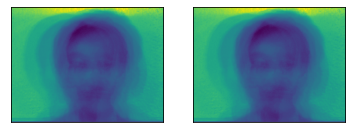

In [15]:
plt.figure(figsize=(20, 5))

results = []
with torch.no_grad():
    trained_model.eval()
    for x in training_data[:2]:
        x = x.to(device)
        x_hat, mu, logvar = trained_model(x)
        x_hat = x_hat.view(243,320) 
        results.append(x_hat)

print(len(results), results[0].shape)

# view 
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
for i in range(len(results)):
    img = results[i]
    ax[i].imshow(img)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.show()

torch.Size([77760])


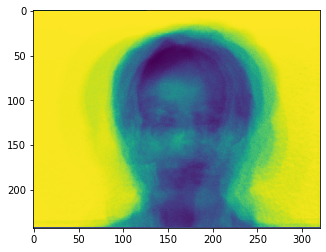

In [16]:
# Generating a few completely random samples and passing them through the decoder 

d = 30
with torch.no_grad():
    z = torch.randn((d)).to(device)
    sample = trained_model.decoder(z)
print(sample.shape)
plt.imshow(sample.view(243,320))

(1014, 1400, 4) 5678400 <class 'numpy.ndarray'>


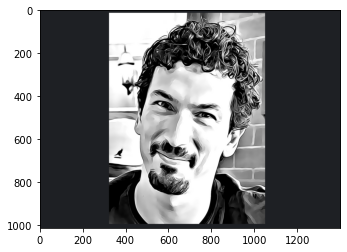

In [17]:
# Try it with other images:

# upload an image
img = mpimg.imread('./pf.png') 
plt.imshow(img) 
print(img.shape, img.size, type(img)) 
plt.imshow(img)

In [18]:
# Resize the uploaded image to (320, 243) and convert it into gray scale to get rid of the 3rd dimension

import torch
from torchvision import transforms
p = transforms.Compose([transforms.Resize((243,320))])

from PIL import Image
img = Image.open('./pf.png')
print('oringinal size', img.size) # original size with 3 colors
img = img.convert('1') # convert image to black and white
# img.save('pf_b_w.png')
pf = p(img) # new rescaled/resized dimensions of image
print('final size', pf.size, type(pf))


oringinal size (1400, 1014)
final size (320, 243) <class 'PIL.Image.Image'>


(243, 320) 77760 <class 'numpy.ndarray'>


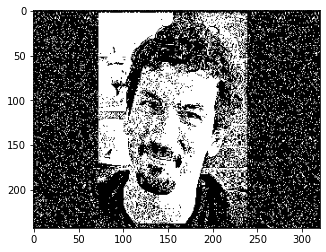

In [19]:
plt.imshow(pf) 
pf = np.array(pf) # np array conversion: (320, 243) becomes (243, 320)
print(pf.shape, pf.size, type(pf)) 

In [20]:
with torch.no_grad():
    pf = torch.tensor(pf).view(-1, 243*320).to(torch.float32)
    result = trained_model(pf)[0]
print(result, len(result[0]))   

tensor([[0.4948, 0.4971, 0.4967,  ..., 0.4234, 0.4260, 0.4237]]) 77760


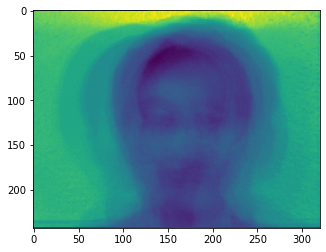

In [21]:
plt.imshow(result.view(243,320))

torch.Size([77760]) torch.Size([1, 77760]) torch.Size([1, 77760])
torch.Size([1, 77760])


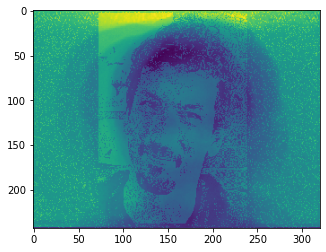

In [22]:
# play with some of the results
# check the shapes of random numbers passing through decoder, the pf passing throught the whole model, and the pf
print(sample.shape, result.shape, pf.shape)
sample = sample.unsqueeze(0)
print(sample.shape)

average = (10*result + pf) # just a touch of the real picture added on the average output of the VAE model 
plt.imshow(average.view(243,320)) # view